In [6]:
import os
import yaml
import torch
import shutil
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from runners.diffusion import Diffusion

torch.set_printoptions(sci_mode=False)
from main import dict2namespace

In [8]:
@dataclass
class Args:
        config: str
        seed = 1234
        exp = 'exp'
        doc = 'docs'
        comment = ""
        verbose = "info"
        test = "None"
        sample = True
        fid = True
        interpolation = None
        resume_training = None
        image_folder = "images"
        ni = None
        use_pretrained = True
        sample_type = "generalized"
        skip_type = "uniform"
        timesteps: int
        eta: float
        sequence = None
        log_path = None
        notebook = True

In [9]:
def setup(args):
    args.log_path = os.path.join(args.exp, "logs", args.doc)
    
    # parse config file
    with open(os.path.join("configs", args.config), "r") as f:
        config = yaml.safe_load(f)
    new_config = dict2namespace(config)

    level = getattr(logging, args.verbose.upper(), None)
    if not isinstance(level, int):
        raise ValueError("level {} not supported".format(args.verbose))

    handler1 = logging.StreamHandler()
    formatter = logging.Formatter(
        "%(levelname)s - %(filename)s - %(asctime)s - %(message)s"
    )
    handler1.setFormatter(formatter)
    logger = logging.getLogger()
    logger.addHandler(handler1)
    logger.setLevel(level)

    if args.sample:
        os.makedirs(os.path.join(args.exp, "image_samples"), exist_ok=True)
        args.image_folder = os.path.join(
            args.exp, "image_samples", args.image_folder
        )
        if not os.path.exists(args.image_folder):
            os.makedirs(args.image_folder)
        else:
            if not (args.fid or args.interpolation):
                overwrite = False
                if args.ni:
                    overwrite = True
                else:
                    response = input(
                        f"Image folder {args.image_folder} already exists. Overwrite? (Y/N)"
                    )
                    if response.upper() == "Y":
                        overwrite = True

                if overwrite:
                    shutil.rmtree(args.image_folder)
                    os.makedirs(args.image_folder)
                else:
                    print("Output image folder exists. Program halted.")
                    sys.exit(0)

    # add device
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    logging.info("Using device: {}".format(device))
    new_config.device = device

    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    torch.backends.cudnn.benchmark = True

    return args, new_config

In [10]:
img_sigma_samples = {}
for sigma in [0.0, 0.25, 0.5, 0.75, 1.0]:
    # Setup model config
    args = Args(config='bedroom.yml', eta=sigma, timesteps=10)
    args, config = setup(args)
    logging.info("Writing log file to {}".format(args.log_path))



    # Sampling logic
    runner = Diffusion(args, config)
    img_sigma_samples[sigma] = runner.sample()


INFO - 1410630650.py - 2023-05-15 20:39:36,751 - Using device: cpu
INFO - 2211918084.py - 2023-05-15 20:39:36,755 - Writing log file to exp/logs/docs


name: ema_lsun_bedroom, root /Users/annegagneux/Documents/MVA_SEM2/GENERATIVE/ddim-code/checkpoints/diffusion_models_converted
/Users/annegagneux/Documents/MVA_SEM2/GENERATIVE/ddim-code/checkpoints/diffusion_models_converted/ema_diffusion_lsun_bedroom_model/model-2388000.ckpt


455MB [02:29, 3.03MB/s]                               


Loading checkpoint /Users/annegagneux/Documents/MVA_SEM2/GENERATIVE/ddim-code/checkpoints/diffusion_models_converted/ema_diffusion_lsun_bedroom_model/model-2388000.ckpt
starting from image 0


Generating image samples for FID evaluation.: 100%|██████████| 1/1 [50:45<00:00, 3045.35s/it]
INFO - 1410630650.py - 2023-05-15 21:32:55,624 - Using device: cpu
INFO - 1410630650.py - 2023-05-15 21:32:55,624 - Using device: cpu
INFO - 2211918084.py - 2023-05-15 21:32:55,658 - Writing log file to exp/logs/docs
INFO - 2211918084.py - 2023-05-15 21:32:55,658 - Writing log file to exp/logs/docs


name: ema_lsun_bedroom, root /Users/annegagneux/Documents/MVA_SEM2/GENERATIVE/ddim-code/checkpoints/diffusion_models_converted
Loading checkpoint /Users/annegagneux/Documents/MVA_SEM2/GENERATIVE/ddim-code/checkpoints/diffusion_models_converted/ema_diffusion_lsun_bedroom_model/model-2388000.ckpt
starting from image 0


Generating image samples for FID evaluation.:   0%|          | 0/1 [49:51<?, ?it/s]


KeyboardInterrupt: 

In [10]:
import pickle 


In [13]:
n_samples = 5
sample_idcs = np.random.choice(32, size=n_samples)
fig, axs = plt.subplots(len(img_sigma_samples), n_samples, figsize=(4 * len(img_sigma_samples), 4 * n_samples))
for i, (sigma, imgs) in enumerate(img_sigma_samples.items()):
    axs[i, 2].set_title(f"Sigma: {sigma}")
    for j, idx in enumerate(sample_idcs):
        axs[i, j].imshow(imgs[idx].permute(1, 2, 0))
        axs[i, j].axis('off')
plt.tight_layout()
plt.savefig('10timesteps_sig_sweep.png', bbox_inches='tight')
plt.show()

NameError: name 'img_sigma_samples' is not defined

**50 timesteps**

In [ ]:
img_sigma_samples = {}
for sigma in [0.0, 0.25, 0.5, 0.75, 1.0]:
    # Setup model config
    args = Args(config='bedroom.yml', eta=sigma, timesteps=50)
    args, config = setup(args)
    logging.info("Writing log file to {}".format(args.log_path))

    # Sampling logic
    runner = Diffusion(args, config)
    img_sigma_samples[sigma] = runner.sample()

    with open('t50_sig_sweep.pkl', 'wb') as f:
        pickle.dump(img_sigma_samples, f)

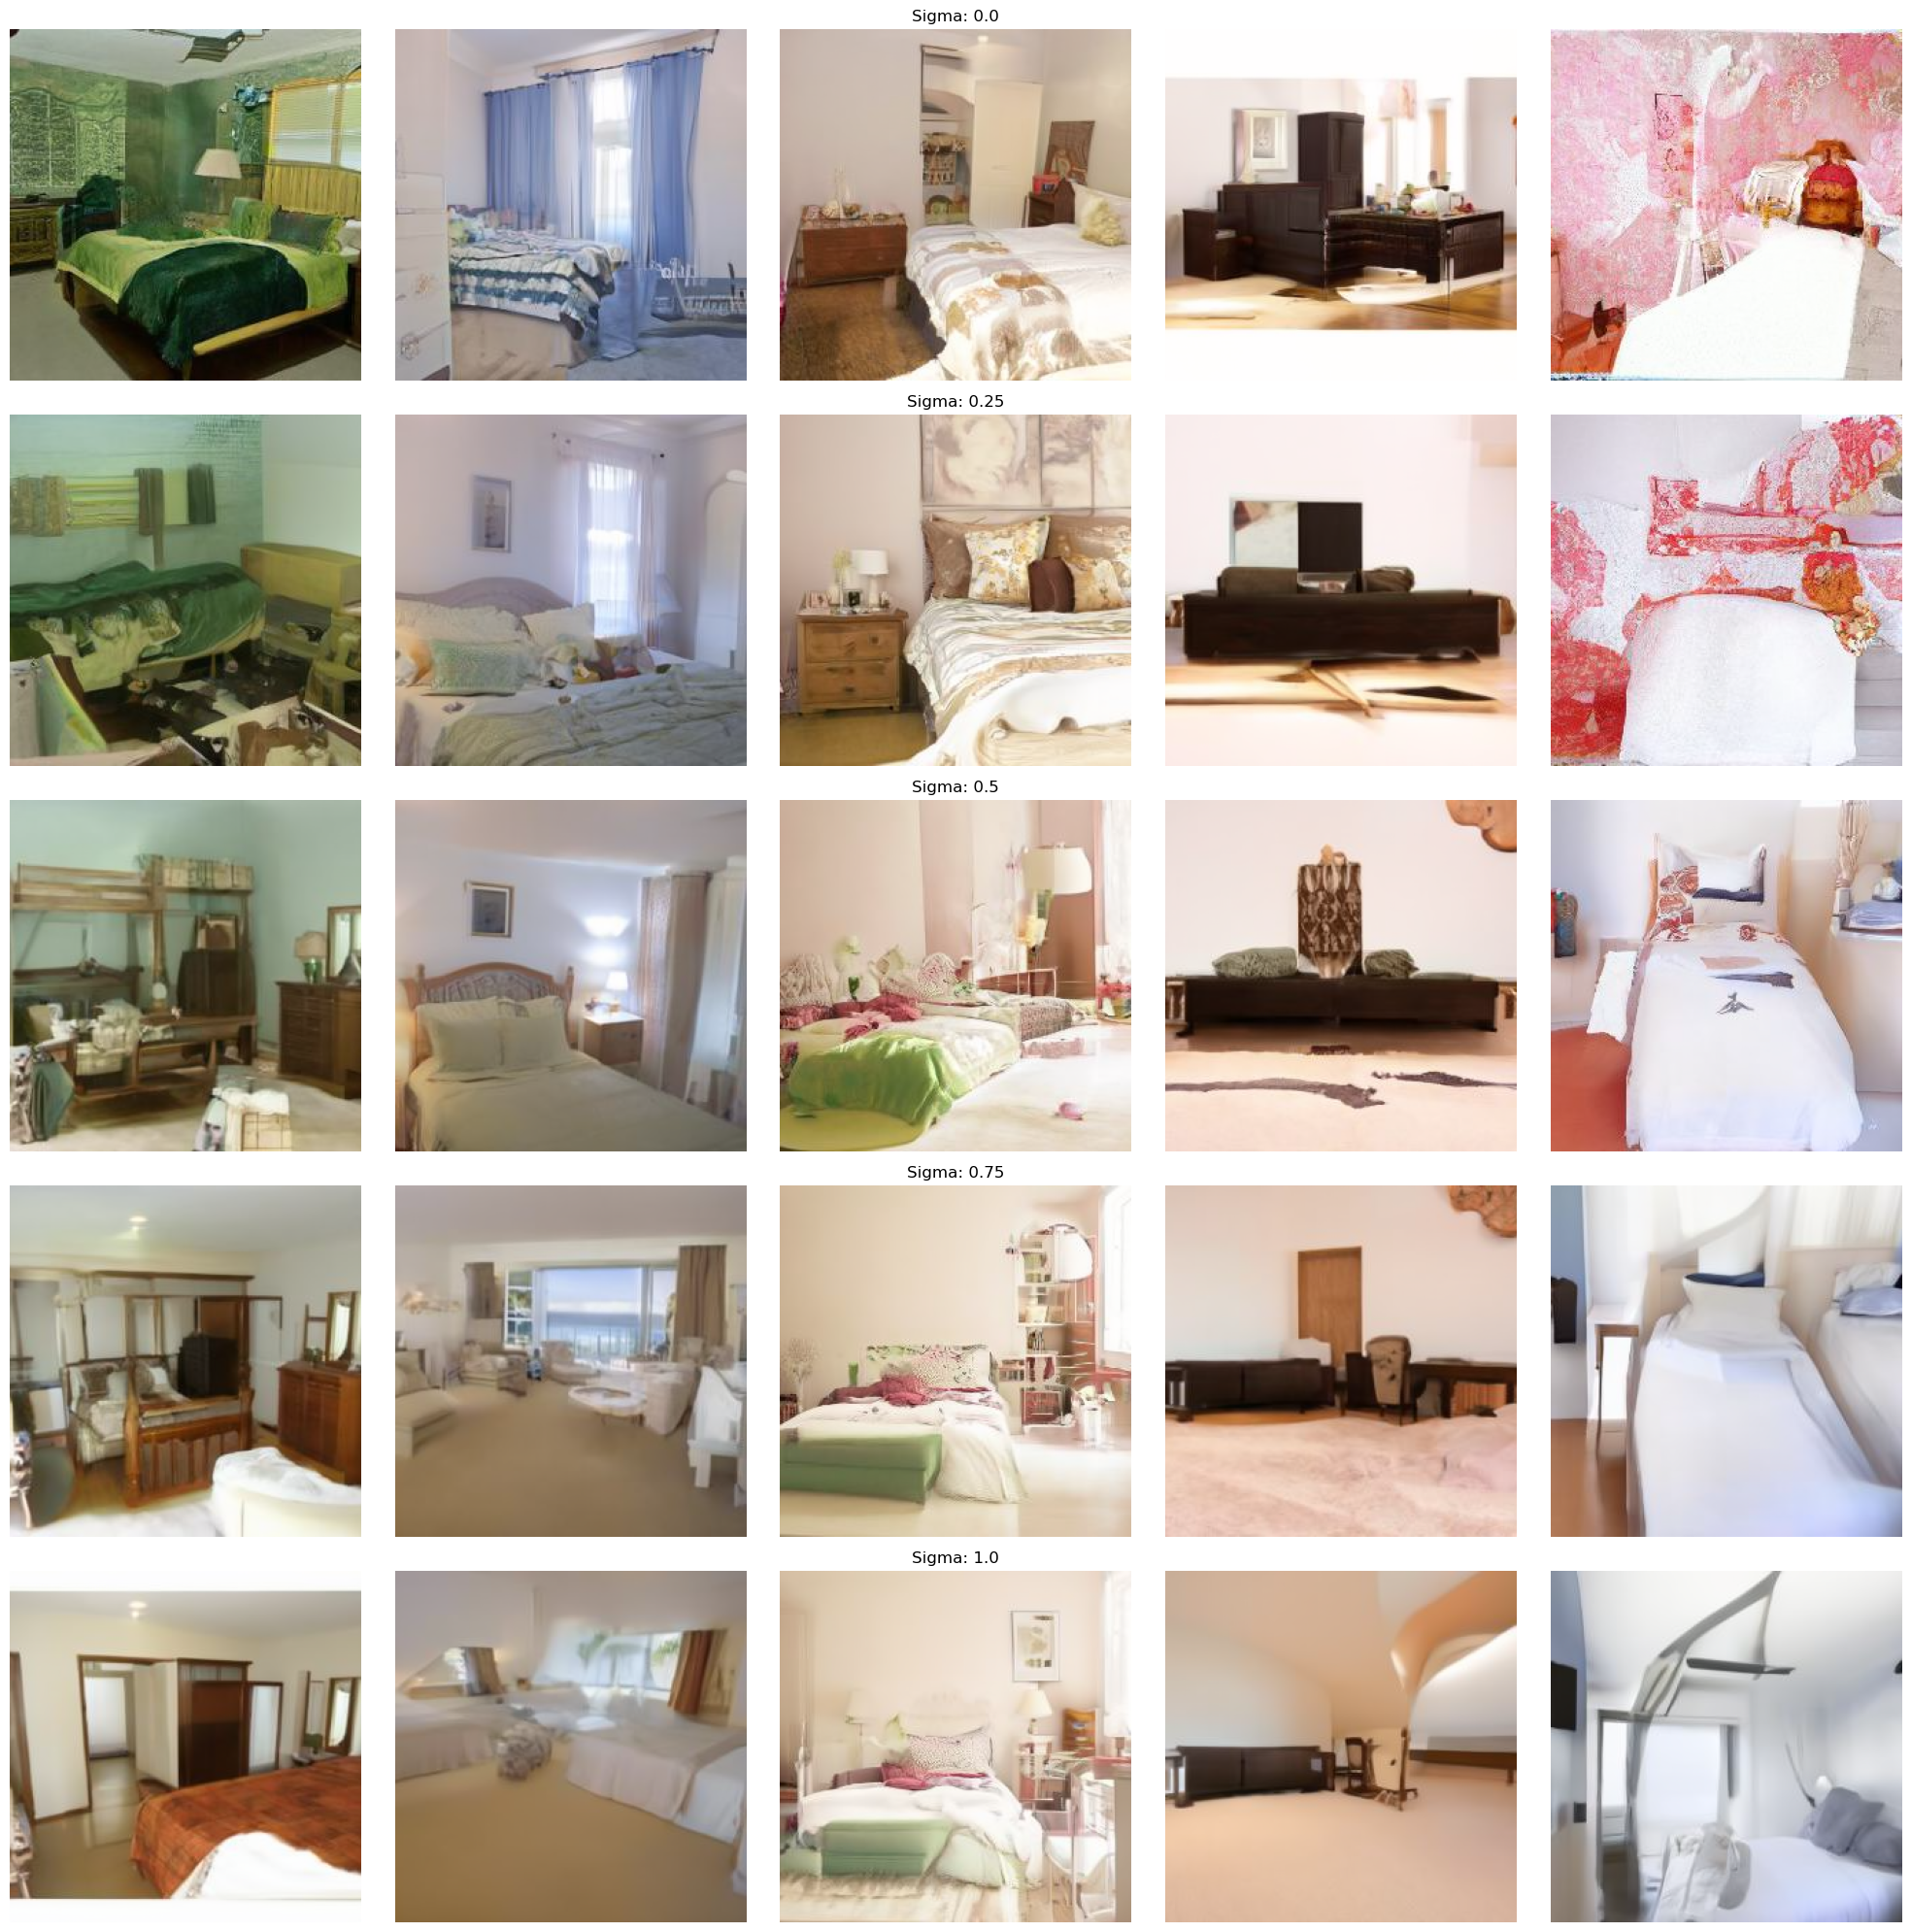

In [50]:
n_samples = 5
sample_idcs = np.random.choice(32, size=n_samples)
fig, axs = plt.subplots(len(img_sigma_samples), n_samples, figsize=(4 * len(img_sigma_samples), 4 * n_samples))
for i, (sigma, imgs) in enumerate(img_sigma_samples.items()):
    axs[i, 2].set_title(f"Sigma: {sigma}")
    for j, idx in enumerate(sample_idcs):
        axs[i, j].imshow(imgs[idx].permute(1, 2, 0))
        axs[i, j].axis('off')
plt.tight_layout()
plt.savefig('10timesteps_sig_sweep.png', bbox_inches='tight')
plt.show()